In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

# Load the dataset
traffic = pd.read_csv("/content/traffic.csv")

# Display the first few rows of the dataset
print(traffic.head())

              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [ ]:
# Check for missing values
if traffic.isnull().any().any():
    print("Dataset contains missing values.")
else:
    print("Dataset does not contain missing values.")

# Check data types
print(traffic.dtypes)

# Convert DateTime to datetime and Junction to categorical
traffic['DateTime'] = pd.to_datetime(traffic['DateTime'])
traffic['Junction'] = traffic['Junction'].astype('category')

# Drop unnecessary column
traffic = traffic.drop(columns=['ID'])

Dataset does not contain missing values.
DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object


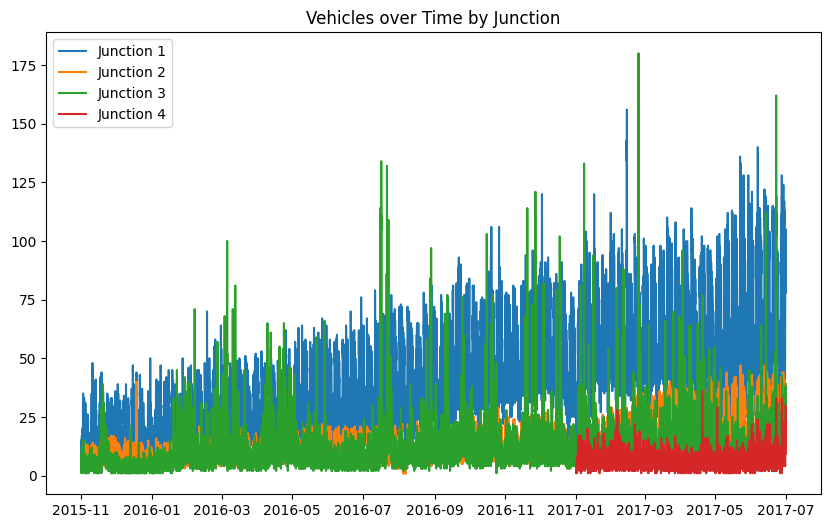

In [ ]:
# Plotting time series
plt.figure(figsize=(10, 6))
for junction in traffic['Junction'].unique():
    subset = traffic[traffic['Junction'] == junction]
    plt.plot(subset['DateTime'], subset['Vehicles'], label=f'Junction {junction}')
plt.legend()
plt.title('Vehicles over Time by Junction')
plt.show()



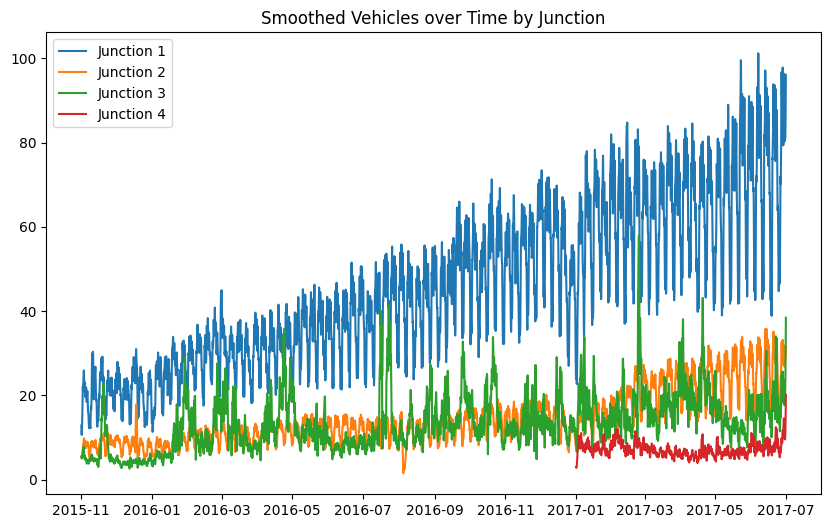

In [ ]:
from scipy.signal import savgol_filter

def smoothing(x):
    return savgol_filter(x, window_length=51, polyorder=3)

traffic['Smooth'] = traffic.groupby('Junction')['Vehicles'].transform(smoothing)

plt.figure(figsize=(10, 6))
for junction in traffic['Junction'].unique():
    subset = traffic[traffic['Junction'] == junction]
    plt.plot(subset['DateTime'], subset['Smooth'], label=f'Junction {junction}')
plt.legend()
plt.title('Smoothed Vehicles over Time by Junction')
plt.show()

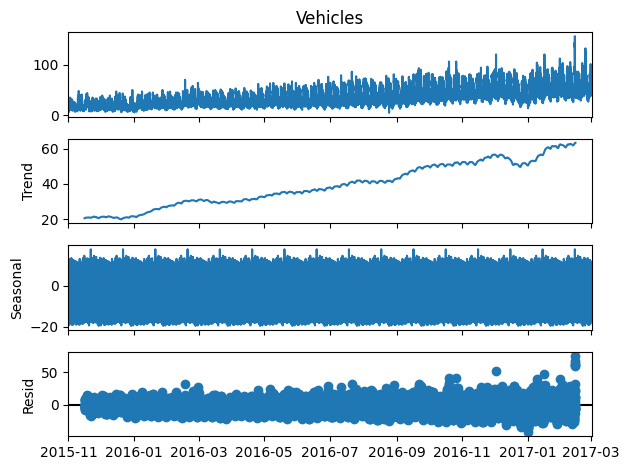

ADF Statistic: -7.013230111320399
p-value: 6.83612992547774e-10
KPSS Statistic: 15.449044870788104
p-value: 0.01


<ipython-input-11-c31cf3ae61e5>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train, regression='c')


In [ ]:
# Filter for Junction 1 and create time series
Junc1 = traffic[traffic['Junction'] == 1].set_index('DateTime')['Vehicles']
train_size = int(len(Junc1) * 0.8)
train, test = Junc1[:train_size], Junc1[train_size:]

# Decompose time series
decomposed = seasonal_decompose(train, model='additive', period=24*30)
decomposed.plot()
plt.show()

# ADF and KPSS tests
adf_result = adfuller(train)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

kpss_result = kpss(train, regression='c')
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

In [ ]:
import itertools

# Define parameter grid
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        temp_model = ARIMA(train, order=param).fit()
        if temp_model.aic < best_aic:
            best_aic = temp_model.aic
            best_pdq = param
            best_model = temp_model
    except:
        continue

print('Best ARIMA Model:', best_pdq)
print(best_model.summary())

# Forecast
forecast_arima = best_model.forecast(steps=len(test))
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
print(f'ARIMA RMSE: {rmse_arima}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dat

Best ARIMA Model: (2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:               Vehicles   No. Observations:                11673
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -35711.351
Date:                Thu, 06 Jun 2024   AIC                          71432.702
Time:                        11:31:44   BIC                          71469.527
Sample:                    11-01-2015   HQIC                         71445.072
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8950      0.003    601.673      0.000       1.889       1.901
ar.L2         -0.9593      0.003   -331.199      0.000      -0.965      -0.954
ma.L1         -1.8786   

In [ ]:
results = pd.DataFrame({
    'Method': ['ARIMA'],
    'RMSE': [rmse_arima]
})

print(results)

  Method       RMSE
0  ARIMA  23.544601
